# FomulaBEAT

変更点
- 低次元で学習させる
- QKVについてもっと詳しく分析する


In [1]:
version = '02-1'
model_dir = './model/' + version
data_path = 'data/eq02.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split('=')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['8+0', '5+2', '5+1'] ['8', '7', '6']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# 辞書と逆辞書を構築
vocab_src = build_vocab(src_data)
vocab_tgt = build_vocab(tgt_data)

print(vocab_tgt)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13}


In [9]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    indexes = indexes.tolist()
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0], vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1], vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  7, 14,  8, 13])
Output: tensor([12,  1,  5, 13])
元に戻した文章
Input: 7+8
Output: 15


In [10]:
batch_size = 128
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [11]:
len(train_data)

8000

Transoformerの設定

In [12]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [13]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size_src: int, vocab_size_tgt: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding_src = TokenEmbedding(vocab_size_src, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, embedding_size)
        decoder_layer = TransformerDecoderLayer(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output = nn.Linear(embedding_size, vocab_size_tgt)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    def encode(self, src: Tensor, mask_src: Tensor):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

In [14]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [15]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [16]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [17]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.1
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


モデルの調査

In [18]:
print(model)

Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 4)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4)
  )
  (transformer_decoder): Transfor

In [19]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


34 層

層名: token_embedding_src.embedding.weight
形状: torch.Size([15, 4])
値: Parameter containing:
tensor([[-0.3925,  0.0219, -0.1580,  0.1845],
        [ 0.4732,  0.5318, -0.3634, -0.2311],
        [-0.2304,  0.5460,  0.0412, -0.3118],
        [-0.0926, -0.1232,  0.0599,  0.3681],
        [-0.1043,  0.4852,  0.3944, -0.4721],
        [-0.0690, -0.0945, -0.2168, -0.4495],
        [ 0.3925,  0.5431,  0.3693, -0.3931],
        [-0.4454,  0.2767,  0.2838,  0.3663],
        [-0.4032,  0.3770, -0.1417, -0.0224],
        [-0.3853, -0.0826, -0.4591, -0.2396],
        [-0.4310,  0.3241,  0.0065,  0.2934],
        [-0.2620,  0.2917, -0.3118,  0.0955],
        [-0.3276,  0.4564, -0.0085, -0.1193],
        [-0.1920, -0.4846,  0.4985, -0.2917],
        [-0.0965,  0.1863, -0.2177,  0.2027]], device='cuda:0', requires_grad=True)

層名: transformer_encoder.layers.0.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[-0.2927, -0.5511, -0.5008,  0.4774],
        [ 0.1951,  0.0

## 学習実行

In [20]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/63 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 63/63 [00:01<00:00, 47.06it/s]


[1/100] train loss: 2.70, valid loss: 2.48  [1s] counter: 0 **


100%|██████████| 63/63 [00:01<00:00, 54.22it/s]


[2/100] train loss: 2.38, valid loss: 2.24  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.05it/s]


[3/100] train loss: 2.15, valid loss: 2.04  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.74it/s]


[4/100] train loss: 1.97, valid loss: 1.84  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.85it/s]


[5/100] train loss: 1.79, valid loss: 1.67  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.30it/s]


[6/100] train loss: 1.65, valid loss: 1.51  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.70it/s]


[7/100] train loss: 1.54, valid loss: 1.41  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.39it/s]


[8/100] train loss: 1.45, valid loss: 1.35  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.02it/s]


[9/100] train loss: 1.40, valid loss: 1.31  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.13it/s]


[10/100] train loss: 1.37, valid loss: 1.29  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.41it/s]


[11/100] train loss: 1.35, valid loss: 1.27  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.55it/s]


[12/100] train loss: 1.34, valid loss: 1.26  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.31it/s]


[13/100] train loss: 1.33, valid loss: 1.24  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.10it/s]


[14/100] train loss: 1.31, valid loss: 1.22  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.98it/s]


[15/100] train loss: 1.29, valid loss: 1.18  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.17it/s]


[16/100] train loss: 1.26, valid loss: 1.14  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.14it/s]


[17/100] train loss: 1.23, valid loss: 1.11  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.41it/s]


[18/100] train loss: 1.20, valid loss: 1.07  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.02it/s]


[19/100] train loss: 1.17, valid loss: 1.05  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.88it/s]


[20/100] train loss: 1.15, valid loss: 1.03  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.53it/s]


[21/100] train loss: 1.12, valid loss: 1.00  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.02it/s]


[22/100] train loss: 1.09, valid loss: 0.99  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.92it/s]


[23/100] train loss: 1.07, valid loss: 0.96  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.22it/s]


[24/100] train loss: 1.05, valid loss: 0.94  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.67it/s]


[25/100] train loss: 1.03, valid loss: 0.92  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.22it/s]


[26/100] train loss: 1.01, valid loss: 0.90  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.57it/s]


[27/100] train loss: 0.99, valid loss: 0.87  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.49it/s]


[28/100] train loss: 0.97, valid loss: 0.85  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.73it/s]


[29/100] train loss: 0.96, valid loss: 0.84  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.35it/s]


[30/100] train loss: 0.94, valid loss: 0.82  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.06it/s]


[31/100] train loss: 0.93, valid loss: 0.79  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.24it/s]


[32/100] train loss: 0.92, valid loss: 0.78  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.66it/s]


[33/100] train loss: 0.90, valid loss: 0.76  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.82it/s]


[34/100] train loss: 0.89, valid loss: 0.74  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.52it/s]


[35/100] train loss: 0.87, valid loss: 0.72  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.36it/s]


[36/100] train loss: 0.87, valid loss: 0.72  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.47it/s]


[37/100] train loss: 0.85, valid loss: 0.70  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.79it/s]


[38/100] train loss: 0.86, valid loss: 0.68  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.92it/s]


[39/100] train loss: 0.84, valid loss: 0.67  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.61it/s]


[40/100] train loss: 0.83, valid loss: 0.66  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.47it/s]


[41/100] train loss: 0.83, valid loss: 0.66  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.46it/s]


[42/100] train loss: 0.82, valid loss: 0.65  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.14it/s]


[43/100] train loss: 0.81, valid loss: 0.64  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.53it/s]


[44/100] train loss: 0.80, valid loss: 0.63  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.90it/s]


[45/100] train loss: 0.79, valid loss: 0.63  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.60it/s]


[46/100] train loss: 0.79, valid loss: 0.62  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.94it/s]


[47/100] train loss: 0.79, valid loss: 0.61  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.34it/s]


[48/100] train loss: 0.79, valid loss: 0.61  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.34it/s]


[49/100] train loss: 0.79, valid loss: 0.61  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 53.80it/s]


[50/100] train loss: 0.77, valid loss: 0.59  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 54.62it/s]


[51/100] train loss: 0.78, valid loss: 0.60  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.17it/s]


[52/100] train loss: 0.77, valid loss: 0.59  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 54.47it/s]


[53/100] train loss: 0.77, valid loss: 0.59  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.20it/s]


[54/100] train loss: 0.77, valid loss: 0.58  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 54.17it/s]


[55/100] train loss: 0.75, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 53.93it/s]


[56/100] train loss: 0.75, valid loss: 0.57  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.39it/s]


[57/100] train loss: 0.75, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.87it/s]


[58/100] train loss: 0.75, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.82it/s]


[59/100] train loss: 0.75, valid loss: 0.56  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.62it/s]


[60/100] train loss: 0.75, valid loss: 0.56  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 55.02it/s]


[61/100] train loss: 0.74, valid loss: 0.55  [1s] counter: 3 **


100%|██████████| 63/63 [00:01<00:00, 54.28it/s]


[62/100] train loss: 0.74, valid loss: 0.55  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.14it/s]


[63/100] train loss: 0.73, valid loss: 0.55  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 55.11it/s]


[64/100] train loss: 0.73, valid loss: 0.54  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.49it/s]


[65/100] train loss: 0.72, valid loss: 0.54  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.86it/s]


[66/100] train loss: 0.73, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.13it/s]


[67/100] train loss: 0.73, valid loss: 0.55  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.48it/s]


[68/100] train loss: 0.73, valid loss: 0.53  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 54.29it/s]


[69/100] train loss: 0.72, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.21it/s]


[70/100] train loss: 0.72, valid loss: 0.54  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.45it/s]


[71/100] train loss: 0.72, valid loss: 0.52  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 55.16it/s]


[72/100] train loss: 0.71, valid loss: 0.54  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.82it/s]


[73/100] train loss: 0.71, valid loss: 0.53  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 55.16it/s]


[74/100] train loss: 0.71, valid loss: 0.52  [1s] counter: 3 **


100%|██████████| 63/63 [00:01<00:00, 54.93it/s]


[75/100] train loss: 0.71, valid loss: 0.51  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.82it/s]


[76/100] train loss: 0.70, valid loss: 0.50  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.88it/s]


[77/100] train loss: 0.70, valid loss: 0.52  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.16it/s]


[78/100] train loss: 0.71, valid loss: 0.51  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 55.13it/s]


[79/100] train loss: 0.69, valid loss: 0.51  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 55.23it/s]


[80/100] train loss: 0.69, valid loss: 0.51  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 54.44it/s]


[81/100] train loss: 0.69, valid loss: 0.50  [1s] counter: 5 


100%|██████████| 63/63 [00:01<00:00, 55.04it/s]


[82/100] train loss: 0.68, valid loss: 0.50  [1s] counter: 6 **


100%|██████████| 63/63 [00:01<00:00, 55.08it/s]


[83/100] train loss: 0.68, valid loss: 0.48  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.78it/s]


[84/100] train loss: 0.68, valid loss: 0.50  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.87it/s]


[85/100] train loss: 0.67, valid loss: 0.48  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 54.97it/s]


[86/100] train loss: 0.67, valid loss: 0.49  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 54.64it/s]


[87/100] train loss: 0.67, valid loss: 0.50  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 54.99it/s]


[88/100] train loss: 0.66, valid loss: 0.48  [1s] counter: 5 **


100%|██████████| 63/63 [00:01<00:00, 55.06it/s]


[89/100] train loss: 0.68, valid loss: 0.49  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.96it/s]


[90/100] train loss: 0.67, valid loss: 0.48  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 54.96it/s]


[91/100] train loss: 0.66, valid loss: 0.48  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 54.97it/s]


[92/100] train loss: 0.66, valid loss: 0.48  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 54.52it/s]


[93/100] train loss: 0.65, valid loss: 0.48  [1s] counter: 5 **


100%|██████████| 63/63 [00:01<00:00, 53.67it/s]


[94/100] train loss: 0.65, valid loss: 0.47  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 54.74it/s]


[95/100] train loss: 0.66, valid loss: 0.47  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.93it/s]


[96/100] train loss: 0.66, valid loss: 0.48  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 54.70it/s]


[97/100] train loss: 0.65, valid loss: 0.48  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 54.89it/s]


[98/100] train loss: 0.65, valid loss: 0.46  [1s] counter: 4 **


100%|██████████| 63/63 [00:01<00:00, 54.70it/s]


[99/100] train loss: 0.65, valid loss: 0.48  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 54.77it/s]


[100/100] train loss: 0.65, valid loss: 0.46  [1s] counter: 2 


学習したモデルの保存

In [21]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [22]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens = len(tokens)

    # Tensorに変換
    src = torch.LongTensor(tokens).reshape(num_tokens, 1).to(device)
    mask_src = torch.zeros((num_tokens, num_tokens), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts, vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    memory = model.encode(src, mask_src)
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [23]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '9+1'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 9+1
Output: 10


## モデルの動作を分析

In [24]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 4)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=4, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 4)
  )
  (transformer_decoder): Transfor

In [25]:
def inspect_model_layers(model, src, tgt):
    # Token Embedding (src)
    src_embedded = model.token_embedding_src(src)
    print("Source Embedding Shape:", src_embedded.shape)
    
    # Token Embedding (tgt)
    tgt_embedded = model.token_embedding_tgt(tgt)
    print("Target Embedding Shape:", tgt_embedded.shape)
    
    # Positional Encoding (src)
    src_pos_encoded = model.positional_encoding(src_embedded)
    print("Source Positional Encoding Shape:", src_pos_encoded.shape)
    
    # Transformer Encoder Layer
    encoder_output = model.transformer_encoder(src_pos_encoded)
    print("Transformer Encoder Output Shape:", encoder_output.shape)
    
    # Transformer Decoder Layer
    decoder_output = model.transformer_decoder(tgt_embedded, encoder_output)
    print("Transformer Decoder Output Shape:", decoder_output.shape)
    
    # Final Output
    final_output = model.output(decoder_output)
    print("Final Output Shape:", final_output.shape)


In [26]:
def inspect_embedding_similarity(model, indices):
    emb = model.token_embedding_src.embedding.weight[indices]
    print("Selected Embeddings:", emb)
    
    # Cosine Similarity
    cosine_sim = torch.nn.functional.cosine_similarity(emb[0], emb[1], dim=0)
    print(f"Cosine Similarity between {indices[0]} and {indices[1]}:", cosine_sim.item())

inspect_embedding_similarity(loaded_model, [7, 6])


Selected Embeddings: tensor([[ 0.8101, -0.0286, -0.3102, -0.0715],
        [ 0.7757,  0.4116, -0.1158, -0.3675]], device='cuda:0', grad_fn=<IndexBackward0>)
Cosine Similarity between 7 and 6: 0.8128422498703003


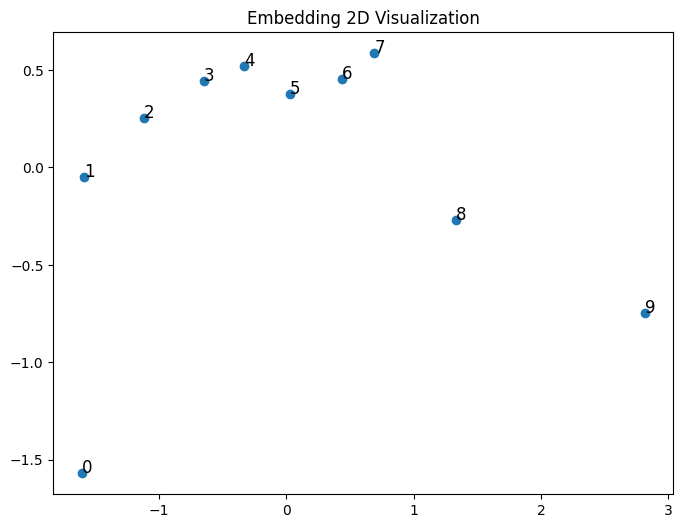

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(model, num_points=10):
    embeddings = model.token_embedding_src.embedding.weight[:num_points].cpu().detach().numpy()
    
    # PCA for 2D visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i in range(num_points):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(i), fontsize=12)
    plt.title("Embedding 2D Visualization")
    plt.show()

visualize_embeddings(loaded_model)


In [28]:
import torch.nn.functional as F

def inspect_qkv_operations(model, src):
    src_embedded = model.token_embedding_src(src)
    src_pos_encoded = model.positional_encoding(src_embedded)
    
    # Extract QKV from first Transformer layer
    attn_layer = model.transformer_encoder.layers[0].self_attn

    print("QKV Shape:", attn_layer.in_proj_weight.shape)
    
    # Q, K, V are projections of the input, which can be computed as:
    q = F.linear(src_pos_encoded, attn_layer.in_proj_weight[:attn_layer.embed_dim, :], attn_layer.in_proj_bias[:attn_layer.embed_dim])
    k = F.linear(src_pos_encoded, attn_layer.in_proj_weight[attn_layer.embed_dim:2*attn_layer.embed_dim, :], attn_layer.in_proj_bias[attn_layer.embed_dim:2*attn_layer.embed_dim])
    v = F.linear(src_pos_encoded, attn_layer.in_proj_weight[2*attn_layer.embed_dim:, :], attn_layer.in_proj_bias[2*attn_layer.embed_dim:])
        
    return q, k, v

q, k, v = inspect_qkv_operations(model, src)

print("Q Shape:", q.shape)
print("K Shape:", k.shape)
print("V Shape:", v.shape)


NameError: name 'src' is not defined

In [ ]:
src_text = "9+3"
src_tensor = torch.tensor(convert_text_to_indexes(src_text, vocab_src)).reshape(-1, 1).to(device)
src_embedded = loaded_model.token_embedding_src(src_tensor)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 埋め込みデータをCPU上で取得し、PCAで2次元に縮小
embeddings = src_embedded.squeeze(1).cpu().detach().numpy()
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 2次元マップを表示
plt.figure(figsize=(6, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# 埋め込みのインデックスに対応する文字をプロット
for i, token in enumerate(src_text):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], token, fontsize=12)

plt.title("Embedding 2D Visualization for '9+3'")
plt.show()



In [ ]:
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_qkv_2d(model, src_text, vocab_src):
    # 数式を埋め込みに変換
    src_tensor = torch.tensor(convert_text_to_indexes(src_text, vocab_src)).reshape(-1, 1).to(device)
    src_embedded = model.token_embedding_src(src_tensor)
    src_pos_encoded = model.positional_encoding(src_embedded)

    # エンコーダのAttention LayerからQ, K, Vを取得
    attn_layer = model.transformer_encoder.layers[0].self_attn

    # Q, K, Vを計算
    q = F.linear(src_pos_encoded, attn_layer.in_proj_weight[:attn_layer.embed_dim, :], attn_layer.in_proj_bias[:attn_layer.embed_dim])
    k = F.linear(src_pos_encoded, attn_layer.in_proj_weight[attn_layer.embed_dim:2*attn_layer.embed_dim, :], attn_layer.in_proj_bias[attn_layer.embed_dim:2*attn_layer.embed_dim])
    v = F.linear(src_pos_encoded, attn_layer.in_proj_weight[2*attn_layer.embed_dim:, :], attn_layer.in_proj_bias[2*attn_layer.embed_dim:])

    # Q, K, Vの2次元変換
    def plot_2d_projection(embeddings, title):
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings.squeeze(1).cpu().detach().numpy())
        plt.figure(figsize=(6, 6))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
        for i, token in enumerate(src_text):
            plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], token, fontsize=12)
        plt.title(title)
        plt.show()

    # Q, K, Vを2次元にプロット
    plot_2d_projection(q, "Q (Query) 2D Projection for '9+3'")
    plot_2d_projection(k, "K (Key) 2D Projection for '9+3'")
    plot_2d_projection(v, "V (Value) 2D Projection for '9+3'")

# 9+3の数式に対してQ, K, Vを表示
visualize_qkv_2d(loaded_model, '9+3', vocab_src)
